### Description
The AICU Image Classifier is the second phase in the pre-processing of the APDU's images collected. The model classifies the images into "pole" and "non-pole" and saves them into separate folders for the image annotation by third-party annotators (Connected Women).

In [ ]:
"""
Google Colab was used for this phase because at that time we don't have access
yet to Databricks.
"""

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
"""
Install and update dependencies. PyTorch was used for the implementation of
ResNet50 model.
"""
!pip install --upgrade transforms
!pip install --upgrade torchvision
!pip install torchmetrics

In [ ]:
"""
Import necessary libraries:
* OS - for file access
* numpy, matplotlib, PIL - for plotting of images
* torch, torchvision - PyTorch library for image classification using ResNet50
                        pre-trained model
"""
import os
import requests
import numpy as np
%matplotlib inline
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, models, transforms

In [ ]:

# Check PyTorch version
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

PyTorch version: 2.0.0+cu118
Is MPS (Metal Performance Shader) built? False
Is MPS available? False
Using device: cpu


In [ ]:
# Mount user's Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Setup path to data folder
input_path = Path('/content/drive/MyDrive/AICU - Classification/AICU - Pole data')

In [ ]:
# Define directories for training and testing datasets
train_dir = input_path /"train"
test_dir = input_path /"test"


## Create PyTorch Generators

In [ ]:
"""
Description:
- The code defines a set of data transformations, such as resizing, augmentation, and normalization, to be applied to the input images. These transformations are specified for both training and testing datasets.
- Image datasets for training and testing are created using the torchvision.datasets.ImageFolder class, which assumes a specific folder structure where each class has its own subdirectory.
- The batch size and the number of worker processes for data loading are set.
- Finally, data loaders are created for both the training and testing datasets using torch.utils.data.DataLoader.

Input Variables:
- train_dir (str): The path to the directory containing the training dataset.
- test_dir (str): The path to the directory containing the testing dataset.

Output Variables:
- data_transforms (dict): A dictionary containing the specified data transformations for both training and testing datasets.
- image_datasets (dict): A dictionary containing the training and testing datasets created using ImageFolder.
- dataloaders (dict): A dictionary containing data loaders for both training and testing datasets, configured with the specified batch size and number of workers.
"""

# Define normalization parameters for image preprocessing
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

# Define data transformations for training and testing datasets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize input images to (224, 224) pixels
        transforms.TrivialAugmentWide(num_magnitude_bins=31),  # Apply a custom augmentation
        transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip images horizontally with a probability of 0.5
        transforms.ToTensor(),  # Convert the image to PyTorch tensor
        normalize  # Normalize the image tensor using pre-defined mean and standard deviation
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),  # Resize input images to (224, 224) pixels
        transforms.ToTensor(),  # Convert the image to PyTorch tensor
        normalize  # Normalize the image tensor using pre-defined mean and standard deviation
    ]),
}

# Create datasets for training and testing using ImageFolder class
image_datasets = {
    'train': datasets.ImageFolder(train_dir, data_transforms['train']),
    'test': datasets.ImageFolder(test_dir, data_transforms['test'])
}

# Set batch size and number of workers for data loaders
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

# Create data loaders for training and testing datasets
dataloaders = {
    'train': torch.utils.data.DataLoader(
        image_datasets['train'],
        batch_size=BATCH_SIZE,
        shuffle=True,
        num_workers=NUM_WORKERS
    ),
    'test': torch.utils.data.DataLoader(
        image_datasets['test'],
        batch_size=BATCH_SIZE,
        shuffle=False,
        num_workers=NUM_WORKERS
    )
}

## Create the Network

The example usage showcases how to use the function to create a pre-trained ResNet50 model with a modified fully connected layer for a custom classification task, and also set up the criterion, optimizer, and number of training epochs.

In [ ]:
from torchvision.models import resnet50, ResNet50_Weights


def create_pretrained_resnet_model_and_optimizer(num_classes=2, device='cuda'):
    """
    Create a pre-trained ResNet50 model with a modified fully connected layer
    for a custom classification task.
    Also, set up the criterion, optimizer, and number of training epochs.

    Parameters:
    - num_classes (int): Number of output classes for the classification task.
    - device (str): The device on which to load the model ('cuda' or 'cpu').

    Returns:
    - model (torch.nn.Module): Pre-trained ResNet50 model with a modified
    fully connected layer for the given number of classes.
    - criterion (torch.nn.Module): CrossEntropyLoss criterion for training the model.
    - optimizer (torch.optim.Optimizer): Adam optimizer for updating model
    parameters during training.
    - num_epochs (int): Number of training epochs.
    """

    # Load ResNet50 model with pre-trained weights
    model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)

    # Freeze all parameters in the model
    for param in model.parameters():
        param.requires_grad = False

    # Modify the fully connected layer for the specific classification task
    model.fc = nn.Sequential(
        nn.Linear(2048, 128),
        nn.ReLU(inplace=True),
        nn.Linear(128, num_classes)
    ).to(device)

    # Define the CrossEntropyLoss criterion
    criterion = nn.CrossEntropyLoss()

    # Define the Adam optimizer for updating the model parameters
    optimizer = optim.Adam(model.fc.parameters())

    # Set the number of training epochs
    num_epochs = 1

    return model, criterion, optimizer, num_epochs


In [ ]:
# Create pre-trained ResNet model
model, criterion, optimizer, num_epochs = create_pretrained_resnet_model_and_optimizer(num_classes=2, device='cuda')

## Train the Model

In [ ]:
def train_model(model, criterion, optimizer, num_epochs, dataloaders, image_datasets, device='cuda'):
    """
    Train a PyTorch model on a given dataset.

    Parameters:
    - model (torch.nn.Module): The PyTorch model to be trained.
    - criterion (torch.nn.Module): The loss function used for training.
    - optimizer (torch.optim.Optimizer): The optimization algorithm.
    - num_epochs (int): The number of training epochs.
    - dataloaders (dict): A dictionary containing training and testing data loaders.
    - image_datasets (dict): A dictionary containing training and testing datasets.
    - device (str): The device on which to perform training ('cuda' or 'cpu').

    Returns:
    - model (torch.nn.Module): The trained PyTorch model.
    """

    # Set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Early stopping
    last_loss = 1.00
    patience = 2
    triggertimes = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))

            # Early stopping
            if phase == 'test':
                if epoch_loss > last_loss:
                    triggertimes += 1
                    print('Trigger Times: ', triggertimes)

                    if triggertimes >= patience:
                        print('Early stopping!\nStart to test process.')
                        return model
                else:
                    print('Trigger times: 0')
                    triggertimes = 0

            last_loss = epoch_loss

    return model


In [ ]:
# Save the trained model
model_trained = train_model(model, criterion, optimizer, num_epochs)

## Save or Load PyTorch model weights

In [ ]:
def save_and_load_model_weights(model_trained, save_path, load_path=None):
    """
    Save or load PyTorch model weights.

    Parameters:
    - model_trained (torch.nn.Module): The PyTorch model whose weights are to be saved or loaded.
    - save_path (str): Path to save the model weights.
    - load_path (str, optional): Path to load pre-trained weights. If None, the model is saved.

    Returns:
    - model (torch.nn.Module): The PyTorch model with saved or loaded weights.
    """

    # Create directories for saving weights if they don't exist
    !mkdir -p models/pytorch_

    # Save or load the model weights
    if load_path is None:
        # Save the model weights
        torch.save(model_trained.state_dict(), save_path)
    else:
        # Load pre-trained weights from the specified path
        model = models.resnet50(weights=None).to(device)
        model.fc = nn.Sequential(
            nn.Linear(2048, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, 2)
        ).to(device)
        model.load_state_dict(torch.load(load_path))

    return model

In [ ]:
# Save model weights
save_and_load_model_weights(model_trained, 'models/pytorch_/weights_10.pt')

# Load weights from previous training
loaded_model = save_and_load_model_weights(None, None, '/content/drive/MyDrive/AICU - Classification/Poles-Validation/models/pytorch/weights_94_2.pt')


## Function to Predict and Visualize the Images

In [ ]:
def predict_and_visualize(model, data_transforms, validation_path, validation_img_paths, device='cuda'):
    """
    Predict class probabilities for a list of images and visualize the results.

    Parameters:
    - model (torch.nn.Module): The PyTorch model used for prediction.
    - data_transforms (dict): A dictionary containing the data transformations.
    - validation_path (pathlib.Path): The path to the validation dataset.
    - validation_img_paths (list): List of image paths to be used for prediction.
    - device (str): The device on which to perform the prediction ('cuda' or 'cpu').

    Returns:
    - pred_probs (numpy.ndarray): An array containing predicted class probabilities for each image.
    - fig (matplotlib.figure.Figure): The Matplotlib figure containing visualizations of the predicted results.
    - axs (numpy.ndarray): An array of Matplotlib axes used for visualizing individual images.
    """

    # Open images from the specified paths
    img_list = [Image.open(str(validation_path) + '/' + img_path) for img_path in validation_img_paths]

    # Transform images and create a validation batch
    validation_batch = torch.stack([data_transforms['test'](img).to(device) for img in img_list])

    # Make predictions using the model
    pred_logits_tensor = model(validation_batch)

    # Calculate class probabilities using softmax
    pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

    # Visualize the results
    fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
    for i, img in enumerate(img_list):
        ax = axs[i]
        ax.axis('off')
        ax.set_title("{:.0f}% Non-Pole, {:.0f}% Pole".format(100 * pred_probs[i, 0], 100 * pred_probs[i, 1]))
        ax.imshow(img)

    return pred_probs, fig, axs

### Set Image Paths

In [ ]:
# Set folder path of the images
validation_path = Path('/content/drive/MyDrive/AICU - Classification/Poles-Validation/Sub_Folder_2022')

# Create a list of image filenames for validation
validation_img_paths = ["Folder_2019pbr_ALISTAIR YBAÑEZ 07-26-19_1026640_0_MBL321_0_IMG_20190726_161922.jpg",
                        "Folder_2019pbr_ALISTAIR YBAÑEZ 07-31-19_0174452_C13023_MBL321_0_B_IMG_20190731_114343.jpg",
                        "Folder_2019pbr_ALISTAIR YBAÑEZ 08-23-19_0414203_0_PRD312_0_A_IMG_20190823_145628.jpg"]

img_list = [Image.open(str(validation_path) + '/' + img_path) for img_path in validation_img_paths]

# Prediction on Few Images for Validation and Plotting the Images

In [ ]:
# Call the function predict_and_visualize
pred_probs, fig, axs = predict_and_visualize(loaded_model, data_transforms, validation_path, validation_img_paths)


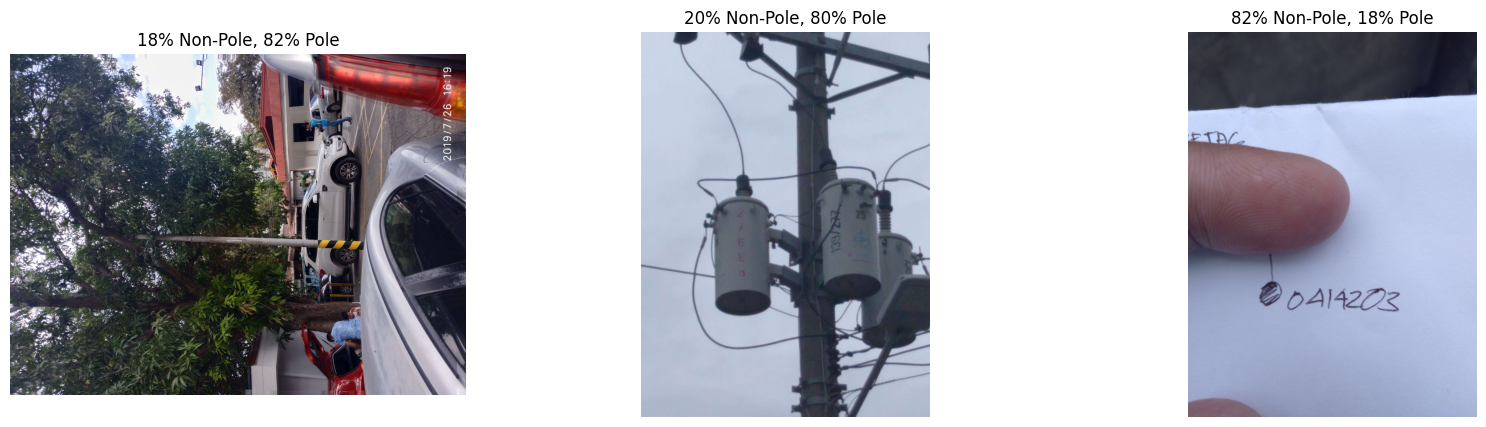

In [ ]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% Non-Pole, {:.0f}% Pole".format(100*pred_probs[i,0],
                                                            100*pred_probs[i,1]))
    ax.imshow(img)

## Predict Unseen Data without Plotting the Images

In [ ]:
from typing import List, Tuple
from PIL import Image
import os
import cv2 as cv
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

def pred_and_save_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: transforms.Compose = None,
                        device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')):
    """
    Perform prediction on a single image using a trained PyTorch model and plot the result.

    Parameters:
    - model (torch.nn.Module): The PyTorch model used for prediction.
    - image_path (str): Path to the input image.
    - class_names (List[str]): List of class names for interpreting the predictions.
    - image_size (Tuple[int, int]): Size to which the input image is resized before prediction.
    - transform (torchvision.transforms.Compose): Custom transform to apply to the input image.
    - device (torch.device): Device on which to perform the prediction ('cuda' or 'cpu').

    Returns:
    None
    """

    # 1. Open Image
    img = Image.open(image_path)

    # 2. Create transformation for image (if it doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

    # 3. Make sure the model is on the target device
    model.to(device)

    # 4. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # 5. Transform and add an extra dimension to image (model requires samples in [batch_size, color channels, height, width])
        transformed_image = image_transform(img).unsqueeze(dim=0)

        # 6. Make prediction on the image with an extra dimension and send it to the target device
        target_image_pred = model(transformed_image.to(device))

    # 7. Convert logits to prediction probabilities
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 8. Convert prediction probabilities to prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)
    print(target_image_pred_label)

    # 9. Print predicted label and probability
    # print(f"Pred: {class_names[target_image_pred_label]} | Prob: {100*target_image_pred_probs.max():.2f}%")

    # 10. Save image
    base_filename = os.path.basename(image_path)
    title, ext = os.path.splitext(base_filename)

    img_folder = os.path.dirname(image_path)  # folder with contractor's name and date (e.g., Sub_Folder_2022)
    cname_date = os.path.basename(img_folder)
    # print('Image Folder: ', cname_date)

    cd_name = os.getcwd()
    cname = os.path.basename(cd_name)
    # print("Current Directory", cname)  # folder with contractor's name (e.g., Poles-Validation)

    new_fname = cname + '_' + '_' + base_filename  # removed +cname_date
    # print('New Filename: ', new_fname)

    if target_image_pred_label == 0:
        to_nonpole = os.path.join(DESTN_PATH_NP, new_fname)  # title + ext
        img.save(to_nonpole)
        print(f'Saving image to Non-Pole {DESTN_PATH_NP}')
    else:
        to_pole = os.path.join(DESTN_PATH_P, new_fname)
        img.save(to_pole)
        print(f'Saving image to Pole {DESTN_PATH_P}')


# Make Predictions and Save the Images

In [ ]:
from typing import List, Tuple
from PIL import Image
import os
import cv2 as cv

nonpole = os.path.join(validation_path, "Non-Pole")
pole = os.path.join(validation_path, "Pole")

# Set folder paths for Pole and Non-Pole Predictions
DESTN_PATH_NP = nonpole #'/content/drive/MyDrive/AICU - Classification/Poles-Validation/Non-Pole'
DESTN_PATH_P = pole #'/content/drive/MyDrive/AICU - Claification/Poles-Validation/Pole'

In [ ]:

#os.chdir('/content/drive/MyDrive/AICU - Classification/Poles-Validation/Sub_Folder_2022')

for image_path in test_image_path:
    pred_and_save_image(model=model,
                         image_path=image_path,
                         class_names=class_names,
                         image_size=(224, 224))